In [ ]:
# Install required libraries (run only if not already installed)
# !pip install yfinance newsapi-python nltk scikit-learn matplotlib torch


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from newsapi import NewsApiClient
import yfinance as yf
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


Download VADER Lexicon & Initialize Sentiment Analyzer

In [ ]:
# Download VADER lexicon (run only once)
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Initialize NewsAPI client
newsapi = NewsApiClient(api_key='a2281a1f05fd405fad0487facd2008e7')
# Collect headlines day by day (safe range)
all_headlines = []

for i in range(28, 0, -1):  #  Last 28 days (excludes Feb 27 issue)
    from_date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')
    to_date = (datetime.now() - timedelta(days=i - 1)).strftime('%Y-%m-%d')

    try:
        response = newsapi.get_everything(
            q='stock OR market OR finance',
            from_param=from_date,
            to=to_date,
            language='en',
            sort_by='relevancy',
            page_size=100
        )
        for article in response['articles']:
            all_headlines.append({
                'date': from_date,
                'headline': article['title']
            })
    except Exception as e:
        print(f"Error fetching for {from_date}: {e}")

# Convert to DataFrame
news_df = pd.DataFrame(all_headlines)
news_df['date'] = pd.to_datetime(news_df['date']).dt.date

# Save to CSV for reuse
news_df.to_csv("news_headlines.csv", index=False)

# Preview
news_df.head()


,date,headline
0,2025-02-28,Garmin Fenix 7X Pro Solar Smartwatch Is at an ...
1,2025-02-28,Samsung’s Super Cheap Galaxy A-Series Smartpho...
2,2025-02-28,"This Weekend Only, Coursera Plus Is 40% Off an..."
3,2025-02-28,A top 3% fund manager warns a 'multi-year bear...
4,2025-02-28,Meme coins aren’t subject to securities regula...


Cell 5 – Apply VADER Sentiment Analysis
This will:

Compute a compound sentiment score for each headline

Group the scores by date to get the daily average sentiment

In [ ]:
# Apply VADER sentiment scoring to each headline
news_df['vader_score'] = news_df['headline'].apply(lambda text: vader.polarity_scores(text)['compound'])

# Group by date to compute average daily sentiment
daily_sentiment = news_df.groupby('date').agg({'vader_score': 'mean'}).reset_index()

# Preview
daily_sentiment.head()


,date,vader_score
0,2025-02-28,0.049385
1,2025-03-01,0.096337
2,2025-03-02,0.027574
3,2025-03-03,0.000748
4,2025-03-04,-0.004823


Cell 6 – Download & Prepare Stock Price Data (90 Days)

In [ ]:
# Download 90 days of AAPL stock data
stock_data = yf.download("AAPL", period="90d", interval="1d")

# Reset index
stock_data = stock_data.reset_index()

# Flatten MultiIndex column names (if needed)
stock_data.columns = [
    '_'.join(col).strip().lower() if isinstance(col, tuple) else col.lower()
    for col in stock_data.columns
]

# Rename relevant columns
stock_data = stock_data.rename(columns={
    'date_': 'date',
    'close_aapl': 'close',
    'volume_aapl': 'volume'
})

# Clean and convert date
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date
stock_data = stock_data[['date', 'close', 'volume']]
stock_data = stock_data.sort_values('date')

# Preview
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,date,close,volume
0,2024-11-14,227.969360,44923900
1,2024-11-15,224.752884,47923700
2,2024-11-18,227.769577,44686000
3,2024-11-19,228.029282,36211800
4,2024-11-20,228.748489,35169600


Cell 7 – Merge Stock Prices with Sentiment Scores

In [ ]:
# Merge stock data with daily sentiment on the 'date' column
merged_df = pd.merge(stock_data, daily_sentiment, on='date', how='inner')

# Sort to ensure proper order
merged_df = merged_df.sort_values('date')

# Show merged result
merged_df.head()


,date,close,volume,vader_score
0,2025-02-28,241.839996,56833400,0.049385
1,2025-03-03,238.029999,47184000,0.000748
2,2025-03-04,235.929993,53798100,-0.004823
3,2025-03-05,235.740005,47227600,0.013782
4,2025-03-06,235.330002,45170400,0.003658


Cell 8 – Add Moving Averages, Daily Return, Lagged Price, and Log Volume

In [ ]:
# Add moving averages
merged_df['ma_5'] = merged_df['close'].rolling(window=5).mean()
merged_df['ma_10'] = merged_df['close'].rolling(window=10).mean()

# Add daily return
merged_df['daily_return'] = merged_df['close'].pct_change()

# Add lagged price (yesterday's close)
merged_df['lag_1'] = merged_df['close'].shift(1)

# Add log volume
merged_df['log_volume'] = np.log1p(merged_df['volume'])

# Drop rows with NaNs (caused by rolling and shifting)
merged_df = merged_df.dropna().reset_index(drop=True)

# Final preview
merged_df.head()


,date,close,volume,vader_score,ma_5,ma_10,daily_return,lag_1,log_volume
0,2025-03-13,209.679993,61368300,-0.008945,222.809998,230.091998,-0.033644,216.979996,17.932404
1,2025-03-14,213.490005,60107600,0.029596,217.693997,227.256999,0.018171,209.679993,17.911647
2,2025-03-17,214.000000,48073400,0.027270,214.997998,224.853999,0.002389,213.490005,17.688240
3,2025-03-18,212.690002,42432400,0.013465,213.367999,222.530000,-0.006121,214.000000,17.563423
4,2025-03-19,215.240005,54385400,-0.028385,213.020001,220.480000,0.011989,212.690002,17.811606


Cell 9 – Prepare LSTM Input Sequences

In [ ]:
# Set seq_length to 5 to generate more training sequences
seq_length = 5

# Create sequences for LSTM
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Train/test split
split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

# Confirm new shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: torch.Size([4, 5, 6])
y_train shape: torch.Size([4, 1])


Cell 10 – Build & Train LSTM Model

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use last time step
        return out

# Re-initialize model
model = LSTMModel(input_size)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = loss_fn(output, y_train)

    optimizer.zero_grad()
    loss.backward()

    # Clip gradients to avoid NaNs
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.443186
Epoch 20: Loss = 0.063731
Epoch 40: Loss = 0.044055
Epoch 60: Loss = 0.003317
Epoch 80: Loss = 0.001651
Epoch 100: Loss = 0.000687
Epoch 120: Loss = 0.001483
Epoch 140: Loss = 0.000904
Epoch 160: Loss = 0.000184
Epoch 180: Loss = 0.000506


Cell 11 – Evaluate Model on Test Data

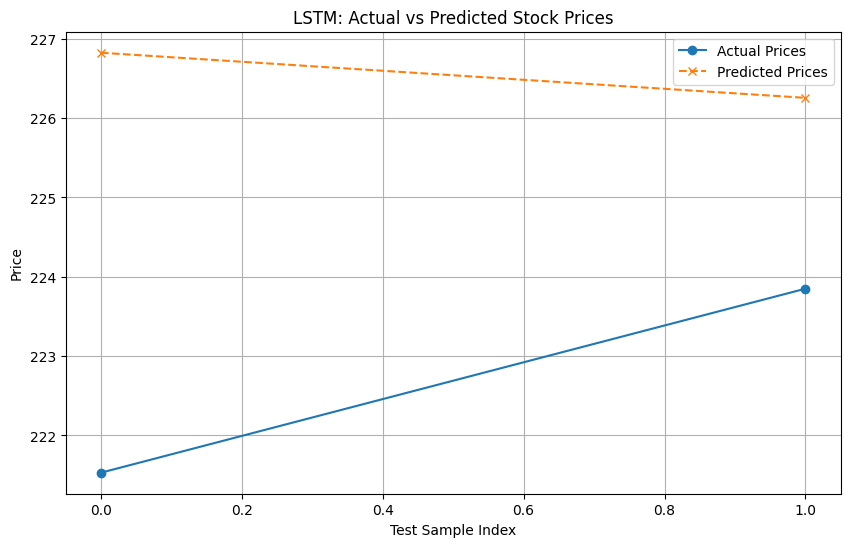

Mean Absolute Error (MAE): 3.8501052856445312


In [ ]:
# Switch to eval mode for prediction
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(X_test)

# Inverse scale predictions and actual values
y_pred_inv = scaler_y.inverse_transform(y_pred.numpy())
y_test_inv = scaler_y.inverse_transform(y_test.numpy())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Prices', marker='o', linestyle='-')
plt.plot(y_pred_inv, label='Predicted Prices', marker='x', linestyle='--')
plt.title("LSTM: Actual vs Predicted Stock Prices")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate performance
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae}")


In [ ]:
# Use only the most important features for the LSTM model
feature_cols_simplified = ['close', 'daily_return', 'ma_5', 'ma_10']  # Simplified features
target_col_simplified = 'close'

# Scale the features and target
scaler_X_simplified = MinMaxScaler()
X_scaled_simplified = scaler_X_simplified.fit_transform(merged_df[feature_cols_simplified])

scaler_y_simplified = MinMaxScaler()
y_scaled_simplified = scaler_y_simplified.fit_transform(merged_df[[target_col_simplified]])

# Create sequences for the LSTM
X_seq_simplified, y_seq_simplified = create_sequences(X_scaled_simplified, y_scaled_simplified, seq_len=5)

# Convert to PyTorch tensors
X_tensor_simplified = torch.tensor(X_seq_simplified, dtype=torch.float32)
y_tensor_simplified = torch.tensor(y_seq_simplified, dtype=torch.float32)

# Train/test split
split_idx_simplified = int(0.8 * len(X_tensor_simplified))
X_train_simplified, X_test_simplified = X_tensor_simplified[:split_idx_simplified], X_tensor_simplified[split_idx_simplified:]
y_train_simplified, y_test_simplified = y_tensor_simplified[:split_idx_simplified], y_tensor_simplified[split_idx_simplified:]

# Model Architecture with fewer layers
class SimplifiedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(SimplifiedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use last time step output
        return out

# Initialize model
model_simplified = SimplifiedLSTMModel(input_size=X_train_simplified.shape[2], hidden_size=128, num_layers=2)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_simplified.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model_simplified.train()
    output = model_simplified(X_train_simplified)
    loss = loss_fn(output, y_train_simplified)

    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model_simplified.parameters(), max_norm=1.0)

    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.437802
Epoch 20: Loss = 0.065331
Epoch 40: Loss = 0.023261
Epoch 60: Loss = 0.004740
Epoch 80: Loss = 0.001823
Epoch 100: Loss = 0.000186
Epoch 120: Loss = 0.001077
Epoch 140: Loss = 0.001402
Epoch 160: Loss = 0.002802
Epoch 180: Loss = 0.000721


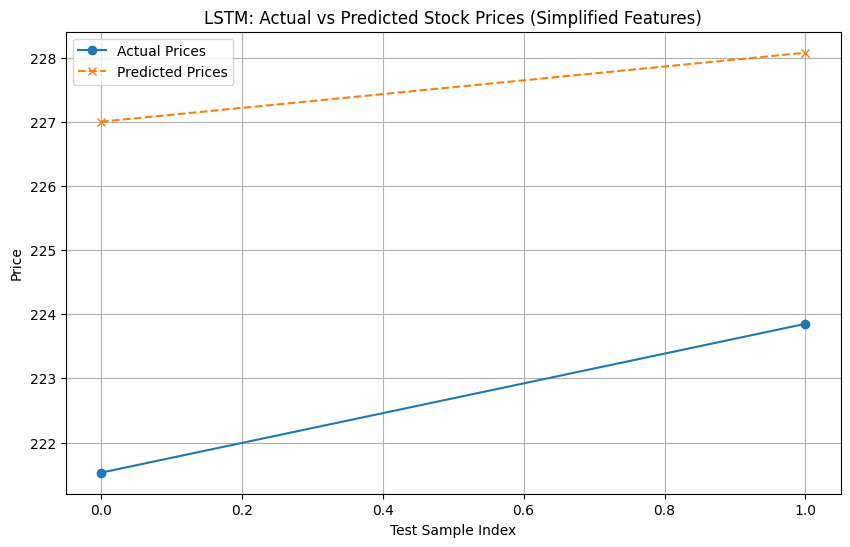

Mean Absolute Error (MAE): 4.8474884033203125


In [ ]:
# Switch to eval mode for prediction
model_simplified.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model_simplified(X_test_simplified)

# Inverse scale predictions and actual values
y_pred_inv = scaler_y_simplified.inverse_transform(y_pred.numpy())
y_test_inv = scaler_y_simplified.inverse_transform(y_test_simplified.numpy())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Prices', marker='o', linestyle='-')
plt.plot(y_pred_inv, label='Predicted Prices', marker='x', linestyle='--')
plt.title("LSTM: Actual vs Predicted Stock Prices (Simplified Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate performance
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae}")


In [ ]:
# Check the dates in the sentiment data to verify the number of days
print("Dates in sentiment data:")
print(daily_sentiment['date'].unique())

# Check the number of data points (rows) in sentiment data
print("Total number of sentiment data points:", len(daily_sentiment))


Dates in sentiment data:
[datetime.date(2025, 2, 28) datetime.date(2025, 3, 1)
 datetime.date(2025, 3, 2) datetime.date(2025, 3, 3)
 datetime.date(2025, 3, 4) datetime.date(2025, 3, 5)
 datetime.date(2025, 3, 6) datetime.date(2025, 3, 7)
 datetime.date(2025, 3, 8) datetime.date(2025, 3, 9)
 datetime.date(2025, 3, 10) datetime.date(2025, 3, 11)
 datetime.date(2025, 3, 12) datetime.date(2025, 3, 13)
 datetime.date(2025, 3, 14) datetime.date(2025, 3, 15)
 datetime.date(2025, 3, 16) datetime.date(2025, 3, 17)
 datetime.date(2025, 3, 18) datetime.date(2025, 3, 19)
 datetime.date(2025, 3, 20) datetime.date(2025, 3, 21)
 datetime.date(2025, 3, 22) datetime.date(2025, 3, 23)
 datetime.date(2025, 3, 24) datetime.date(2025, 3, 25)
 datetime.date(2025, 3, 26) datetime.date(2025, 3, 27)]
Total number of sentiment data points: 28


In [ ]:
print("Dates in stock data:", stock_data['date'].unique())
print("Total number of stock data points:", len(stock_data))


Dates in stock data: [datetime.date(2024, 11, 14) datetime.date(2024, 11, 15)
 datetime.date(2024, 11, 18) datetime.date(2024, 11, 19)
 datetime.date(2024, 11, 20) datetime.date(2024, 11, 21)
 datetime.date(2024, 11, 22) datetime.date(2024, 11, 25)
 datetime.date(2024, 11, 26) datetime.date(2024, 11, 27)
 datetime.date(2024, 11, 29) datetime.date(2024, 12, 2)
 datetime.date(2024, 12, 3) datetime.date(2024, 12, 4)
 datetime.date(2024, 12, 5) datetime.date(2024, 12, 6)
 datetime.date(2024, 12, 9) datetime.date(2024, 12, 10)
 datetime.date(2024, 12, 11) datetime.date(2024, 12, 12)
 datetime.date(2024, 12, 13) datetime.date(2024, 12, 16)
 datetime.date(2024, 12, 17) datetime.date(2024, 12, 18)
 datetime.date(2024, 12, 19) datetime.date(2024, 12, 20)
 datetime.date(2024, 12, 23) datetime.date(2024, 12, 24)
 datetime.date(2024, 12, 26) datetime.date(2024, 12, 27)
 datetime.date(2024, 12, 30) datetime.date(2024, 12, 31)
 datetime.date(2025, 1, 2) datetime.date(2025, 1, 3)
 datetime.date(2025,

In [ ]:
print("Merged data length:", len(merged_df))
print("Merged data dates:", merged_df['date'].unique())


Merged data length: 11
Merged data dates: [datetime.date(2025, 3, 13) datetime.date(2025, 3, 14)
 datetime.date(2025, 3, 17) datetime.date(2025, 3, 18)
 datetime.date(2025, 3, 19) datetime.date(2025, 3, 20)
 datetime.date(2025, 3, 21) datetime.date(2025, 3, 24)
 datetime.date(2025, 3, 25) datetime.date(2025, 3, 26)
 datetime.date(2025, 3, 27)]


In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

# Define the date range for the last 28 days
end_date = datetime.today()
start_date = end_date - timedelta(days=28)

# Fetch the stock data for the last 28 days (ensure it's aligned with sentiment data)
stock_data = yf.download("AAPL", start=start_date, end=end_date, interval="1d")

# Reset index to make 'Date' a column again
stock_data = stock_data.reset_index()

# Flatten the columns (if required)
stock_data.columns = [
    '_'.join(col).strip().lower() if isinstance(col, tuple) else col.lower()
    for col in stock_data.columns
]

# Rename relevant columns
stock_data = stock_data.rename(columns={
    'date_': 'date',
    'close_aapl': 'close',
    'volume_aapl': 'volume'
})

# Clean and convert date
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date
stock_data = stock_data[['date', 'close', 'volume']]
stock_data = stock_data.sort_values('date')

# Check the stock data for the last 28 days
print(stock_data.head())

print("Total number of merged data points:", len(merged_data))


[*********************100%***********************]  1 of 1 completed

         date       close    volume
0  2025-02-28  241.839996  56833400
1  2025-03-03  238.029999  47184000
2  2025-03-04  235.929993  53798100
3  2025-03-05  235.740005  47227600
4  2025-03-06  235.330002  45170400
Total number of merged data points: 19
